In [ ]:
# Core Libraries
import os
import time
import shutil
import pathlib
import itertools
import warnings

# Image Processing
from PIL import Image
import cv2

# Data Handling & Visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set_style('darkgrid')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Activation,
    Dropout, BatchNormalization
)
from tensorflow.keras import regularizers

# Suppress warnings
warnings.filterwarnings("ignore")

print('Modules successfully loaded.')

Modules successfully loaded.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive (3).zip to archive (3).zip


In [ ]:
import zipfile
import os

zip_file = 'archive (3).zip'
extract_dir = '/content/Rice_Image_Dataset'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to: {extract_dir}")

Extracted to: /content/Rice_Image_Dataset


In [ ]:
from pathlib import Path

# Define the path to the dataset
data_path = Path("/content/Rice_Image_Dataset/Train")

# Initialize lists
images = []
labels = []

# Traverse dataset directory
for class_folder in data_path.iterdir():
    if class_folder.is_dir():
        label = class_folder.name
        for image_file in class_folder.glob("*.*"):  # catches all image formats
            images.append(str(image_file))
            labels.append(label)

# Create DataFrame
data = pd.DataFrame({'image': images, 'label': labels})
print(f"Total samples loaded: {len(data)}")
print(data['label'].value_counts())

Total samples loaded: 50000
label
Jasmine      10000
Basmati      10000
Karacadag    10000
Ipsala       10000
Arborio      10000
Name: count, dtype: int64


In [ ]:
data.head()

,image,label
0,/content/Rice_Image_Dataset/Train/Jasmine/1285...,Jasmine
1,/content/Rice_Image_Dataset/Train/Jasmine/7919...,Jasmine
2,/content/Rice_Image_Dataset/Train/Jasmine/7087...,Jasmine
3,/content/Rice_Image_Dataset/Train/Jasmine/7197...,Jasmine
4,/content/Rice_Image_Dataset/Train/Jasmine/520.jpg,Jasmine


In [ ]:
data.shape

(50000, 2)

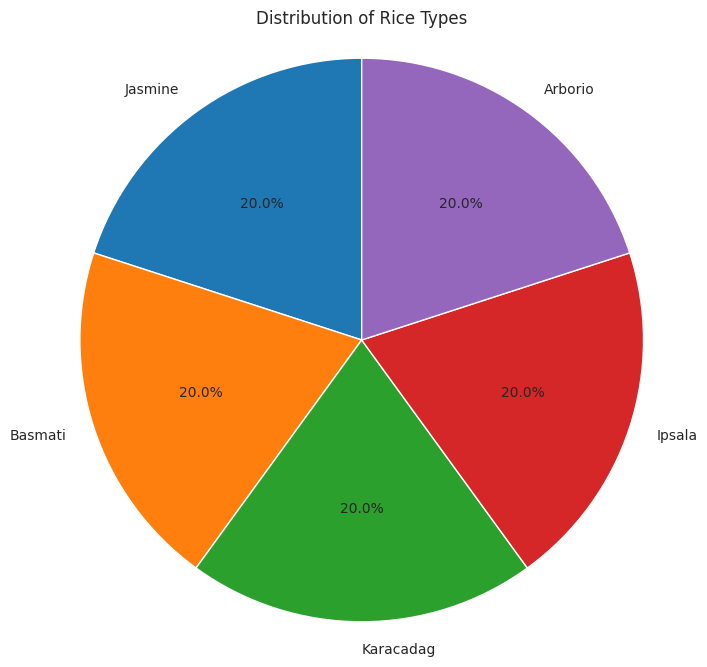

In [ ]:
label_counts = data['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Rice Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

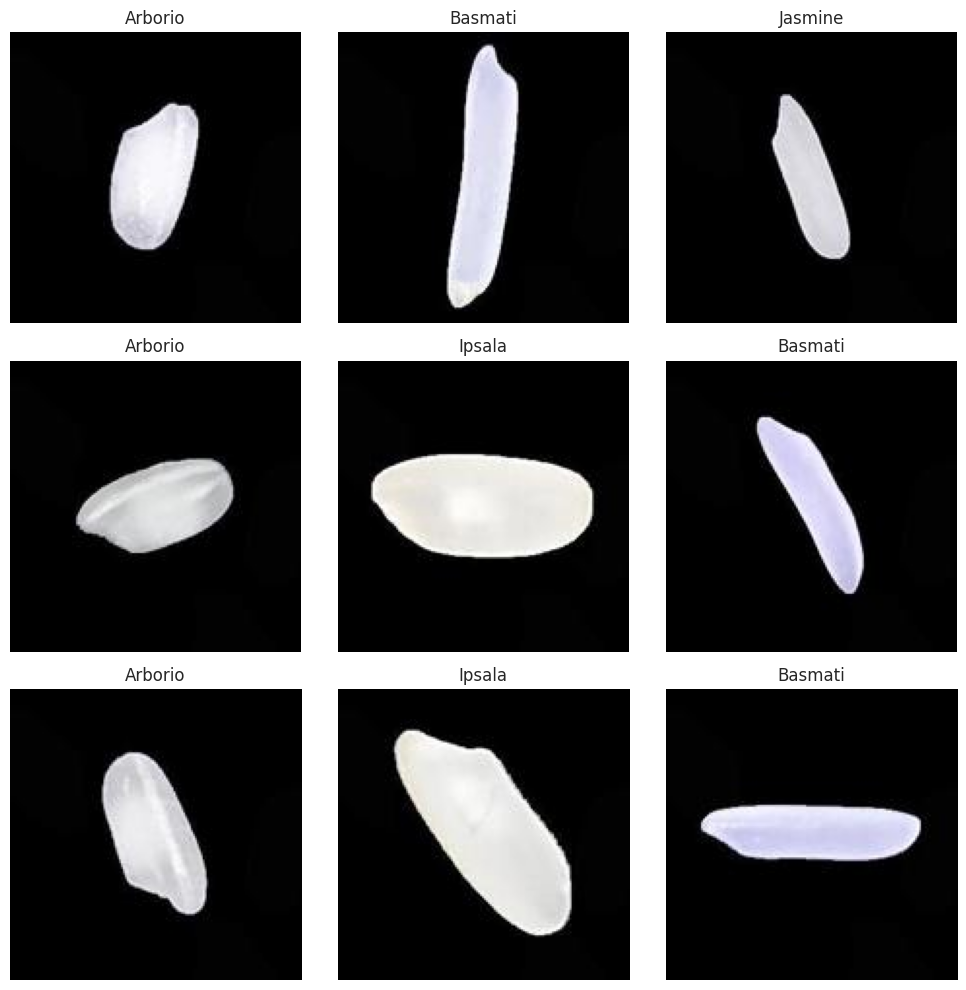

In [ ]:
import matplotlib.image as mpimg

# Set how many images you want to display
num_images = 9
plt.figure(figsize=(10, 10))

# Randomly sample rows from the dataframe
sample_data = data.sample(num_images).reset_index(drop=True)

for i in range(num_images):
    img_path = sample_data.loc[i, 'image']
    label = sample_data.loc[i, 'label']

    img = mpimg.imread(img_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 128
IMG_HEIGHT = 200
IMG_WIDTH = 200
INPUT_SHAPE  = (IMG_HEIGHT, IMG_WIDTH, 3)

Training samples: 40000
Validation samples: 10000


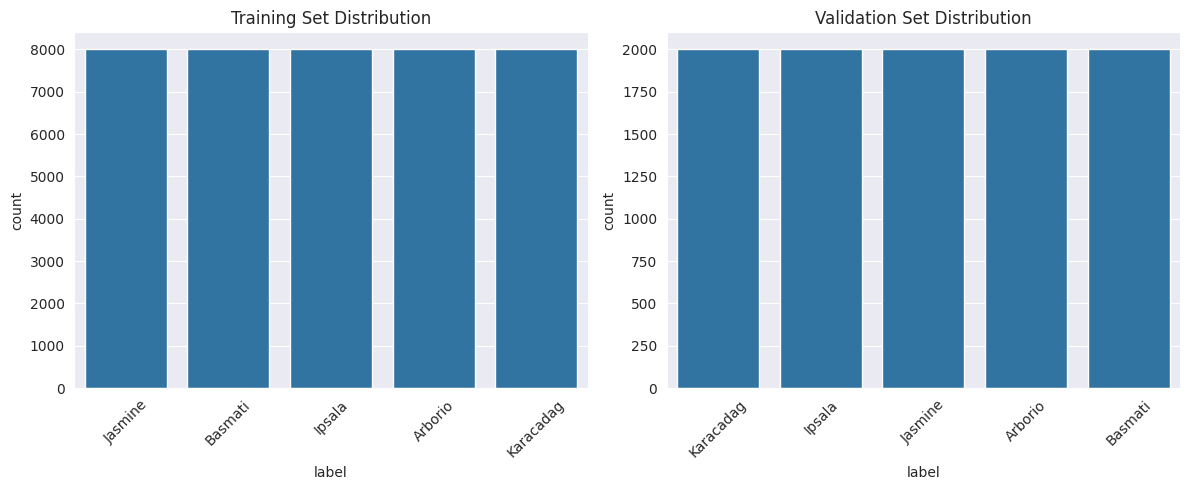

In [ ]:
# Split the data: 80% train, 20% validation
train_df, val_df = train_test_split(
    data,
    test_size=0.2,
    stratify=data['label'],  # Ensures class distribution is preserved
    random_state=42
)

# Reset indices (optional but clean)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Confirm the split
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Optional: visualize class distribution in both sets
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(data=train_df, x='label', ax=axs[0])
axs[0].set_title("Training Set Distribution")
axs[0].tick_params(axis='x', rotation=45)

sns.countplot(data=val_df, x='label', ax=axs[1])
axs[1].set_title("Validation Set Distribution")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Initialize and fit the standardizing ImageDataGenerator
standardize_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

# Fit on training data to compute mean and std
# Note: You need a NumPy array or a small batch to fit
sample_images = np.stack([cv2.resize(cv2.imread(path), (IMG_WIDTH, IMG_HEIGHT)) for path in train_df['image'][:500]])
sample_images = sample_images.astype('float32')  # Make sure type is float
standardize_datagen.fit(sample_images)

# Now use this for training generator
train_generator = standardize_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 40000 validated image filenames belonging to 5 classes.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
cnn_model = keras.Sequential([
    layers.Conv2D(filters=32,kernel_size= (3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32,kernel_size= (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(filters=64,kernel_size= (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64,kernel_size= (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(filters=128,kernel_size= (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=128,kernel_size= (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax'),
    ])

In [ ]:
optimizer = tf.keras.optimizers.Adam()
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 198, 198, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 196, 196, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 196, 196, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 98, 98, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 98, 98, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 96, 96, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 94, 94, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 43, 43, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 29,259,557 (111.62 MB)

 Trainable params: 29,257,381 (111.61 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [ ]:
# Save full model (architecture + weights + optimizer state)
cnn_model.save("cnn_rice_model.h5")
print("Model saved as cnn_rice_model.h5")
warnings.filterwarnings("ignore")

Model saved as cnn_rice_model.h5


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Save the best model based on validation accuracy
checkpoint_cb = ModelCheckpoint(
    "best_cnn_rice_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# Stop training early if no improvement in val_accuracy
earlystop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate if model hits a plateau
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# Combine all callbacks
callbacks_list = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

In [ ]:
# Use the same mean and std for validation data
val_generator = standardize_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 10000 validated image filenames belonging to 5 classes.


In [ ]:
history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks_list
)

warnings.filterwarnings("ignore")

Epoch 1/30
 75/313 ━━━━━━━━━━━━━━━━━━━━ 3:09:58 48s/step - accuracy: 0.8047 - loss: 0.5901

In [ ]:
cnn_model.evaluate(val_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 448ms/step - accuracy: 0.9890 - loss: 0.0311


[0.0352604053914547, 0.9879999756813049]

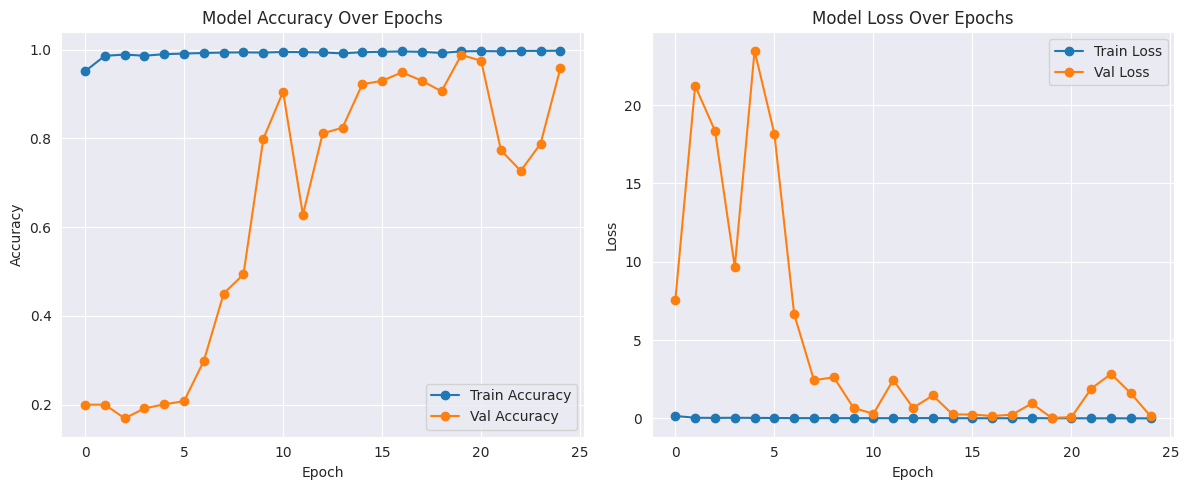

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step
Classification Report:
              precision    recall  f1-score   support

     Arborio       0.96      0.99      0.98       500
     Basmati       1.00      0.99      0.99       500
      Ipsala       1.00      1.00      1.00       500
     Jasmine       0.99      0.97      0.98       500
   Karacadag       0.99      0.99      0.99       500

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



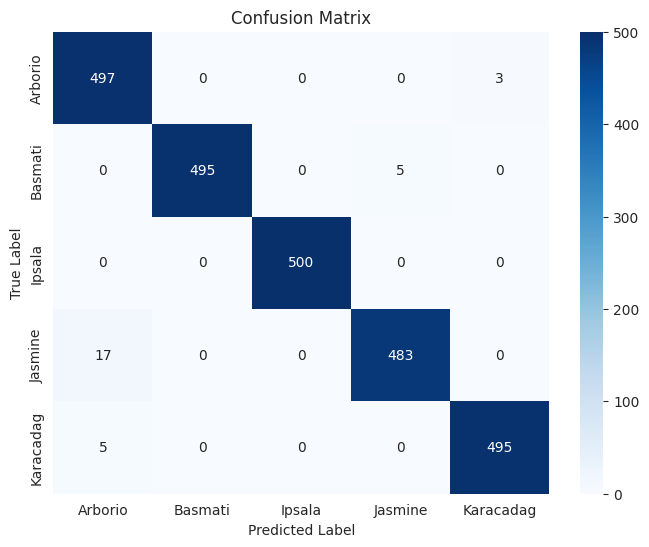

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predicted labels
Y_true = val_generator.classes
Y_pred = cnn_model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Get label names
class_labels = list(val_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels from validation generator
Y_true = val_generator.classes

# Predict using the trained model
Y_pred_probs = cnn_model.predict(val_generator, verbose=1)
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)

# Get class label names
class_labels = list(val_generator.class_indices.keys())

# Print classification report
report = classification_report(Y_true, Y_pred_classes, target_names=class_labels)
print("Classification Report:\n")
print(report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step
Classification Report:

              precision    recall  f1-score   support

     Arborio       0.96      0.99      0.98       500
     Basmati       1.00      0.99      0.99       500
      Ipsala       1.00      1.00      1.00       500
     Jasmine       0.99      0.97      0.98       500
   Karacadag       0.99      0.99      0.99       500

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



#Test

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

def preprocess_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0  # normalize
    return np.expand_dims(img, axis=0)   # add batch dimension

In [ ]:
img_path = '/content/sample_data/Rice_Image_Dataset/Train/Basmati/1019.jpg'  # change based on upload
processed_img = preprocess_image(img_path)

prediction = cnn_model.predict(processed_img)
predicted_class = np.argmax(prediction)

# Map index back to class name
class_indices = train_generator.class_indices
labels_map = dict((v, k) for k, v in class_indices.items())

print(f"Predicted class: {labels_map[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted class: Ipsala


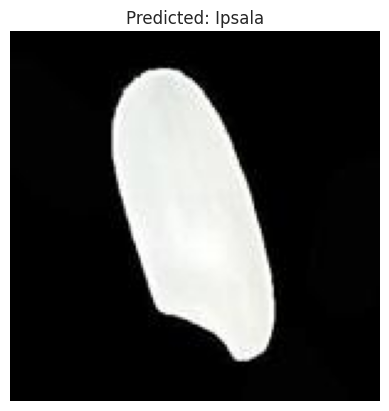

In [ ]:
import matplotlib.pyplot as plt

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Predicted: {labels_map[predicted_class]}")
plt.show()